<a href="https://colab.research.google.com/github/janvierk/MRP/blob/main/MRP_SwahBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from  google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/MRP')

In [ ]:
#installing requitred libries and supressing  the print-out
#!pip install requests==2.31.0 --upgrade -q > NUL
!pip install accelerate -U -q > NUL
!pip install transformers -q > NUL
!pip install torch -q > NUL
#!pip install -U transformers -q >NULip install datasets -q > NUL
!pip install tensorflow -q > NUL
!pip install datasets -q > NUL
!pip install evaluate -q > NUL

In [ ]:
#Required packages and libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers  import Trainer
from transformers import TrainingArguments
from transformers import XLMRobertaTokenizer
from transformers import XLMRobertaForSequenceClassification
from transformers import MT5ForConditionalGeneration
from transformers import T5Tokenizer
import seaborn as sn
import matplotlib
from transformers import AutoTokenizer, AutoModelForTokenClassification
import transformers as tf
import torch
from datasets import load_dataset
import datasets
import  evaluate
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix

In [ ]:
#swahili_datasets
swahili_testing = pd.read_csv("swahili_testing.csv")
swahili_train = pd.read_csv("swahili_train.csv")
swahili_validation = pd.read_csv("swahili_validation.csv")

In [ ]:
english = pd.read_csv("swahili_clean.csv")

In [ ]:
#swahbert tokenizer
tokenizer_swah = BertTokenizer.from_pretrained("pranaydeeps/SwahBERT-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

In [ ]:
#tokenize the data with maximum padding
def tokenize_swah(text, max_length = 512):
  return tokenizer_swah(text,
                   padding = "max_length",
                   truncation = True,
                        max_length = max_length
                    )

In [ ]:
#tokenizing swahili data
tokenized_swahili_train_swahbert =  swahili_train["text"].apply(tokenize_swah)
tokenized_swahili_validation_swahbert = swahili_validation["text"].apply(tokenize_swah)
tokenized_swahili_testing_swahbert = swahili_testing["text"].apply(tokenize_swah)

In [ ]:
#extracting input ids and attention mask for swahbert swahili training
input_ids_swahbert_train= [item["input_ids"] for item in tokenized_swahili_train_swahbert]
attention_swahbert_train = [item["attention_mask"] for item in tokenized_swahili_train_swahbert]
encodings_swahbert_train = {"input_ids": input_ids_swahbert_train,
             "attention_mask": attention_swahbert_train}

In [ ]:
#extracting input ids and attention mask for swahbert swahili validation
input_ids_swahbert_validation= [item["input_ids"] for item in tokenized_swahili_validation_swahbert]
attention_swahbert_validation = [item["attention_mask"] for item in tokenized_swahili_validation_swahbert]
encodings_swahbert_validation = {"input_ids": input_ids_swahbert_validation,
             "attention_mask": attention_swahbert_validation}

In [ ]:
#extracting input ids and attention mask for swahbert swahili testing
input_ids_swahbert_testing= [item["input_ids"] for item in tokenized_swahili_testing_swahbert]
attention_swahbert_testing = [item["attention_mask"] for item in tokenized_swahili_testing_swahbert]
encodings_swahbert_testing = {"input_ids": input_ids_swahbert_testing,
             "attention_mask": attention_swahbert_testing}

In [ ]:
#getting the labels or categories
#getting labels for swahili datasets
swahili_train_labels = swahili_train["label"]
swahili_validation_labels = swahili_validation["label"]
swahili_testing_labels = swahili_testing["label"]

In [ ]:
#creating tensor data to feed into the model
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset (Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)

In [ ]:
#swahili ready data
#english ready data
swahbert_ready_train = TextDataset(encodings_swahbert_train, swahili_train_labels)
swahbert_ready_validation = TextDataset(encodings_swahbert_validation, swahili_validation_labels)
swahbert_ready_testing = TextDataset(encodings_swahbert_testing, swahili_testing_labels)

In [ ]:
#swahbert model
swah_bert_model = BertForSequenceClassification.from_pretrained("pranaydeeps/SwahBERT-base-cased",
                                                                  num_labels = swahili_train["label"].nunique())

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pranaydeeps/SwahBERT-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#importing the metrics
import evaluate
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

In [ ]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn
# Calculate class weights using sklearn's compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(swahili_train_labels), y=swahili_train_labels)

# Convert class weights to a tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
#Define your custom Trainer class with class weights
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to the appropriate device

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define the loss function with class weights
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:

#computing the evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    conf_matrix = confusion_matrix(labels, preds)
    conf_matrix_list = conf_matrix.tolist()

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'conf_matrix': conf_matrix_list
    }

In [ ]:
#training arguments for swahbert
swahbert_arguments = TrainingArguments(
    output_dir="./swahbert_results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir="./swahbert_logging",
    logging_steps=20,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch"
)

In [ ]:
#defining the trainer for swahbert
swahbert_trainer= Trainer(
    model=swah_bert_model,
    args=swahbert_arguments,
    train_dataset=swahbert_ready_train,
    eval_dataset=swahbert_ready_validation,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
"""swahbert_trainer = CustomTrainer(
    model=swah_bert_model,
    args=swahbert_arguments,
    train_dataset=swahbert_ready_train,
    eval_dataset=swahbert_ready_validation,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    class_weights=class_weights  # Pass class weights to the custom trainer
)"""

In [ ]:
#training the swahbert model
swahbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Conf Matrix
1,0.079500,0.430196,0.924860,0.924046,0.923714,0.924860,"[[3031, 32, 36, 58, 58], [82, 256, 0, 0, 0], [24, 0, 505, 2, 21], [73, 0, 2, 125, 0], [34, 9, 11, 2, 1548]]"
2,0.147700,0.443122,0.921306,0.915133,0.918859,0.921306,"[[3089, 10, 29, 16, 71], [83, 242, 0, 0, 13], [30, 0, 485, 2, 35], [136, 0, 3, 61, 0], [34, 1, 2, 0, 1567]]"
3,0.025800,0.522654,0.922999,0.920646,0.920506,0.922999,"[[3013, 76, 38, 34, 54], [56, 280, 0, 0, 2], [12, 0, 522, 3, 15], [107, 0, 7, 86, 0], [35, 4, 10, 2, 1553]]"


Trainer is attempting to log a value of "[[3031, 32, 36, 58, 58], [82, 256, 0, 0, 0], [24, 0, 505, 2, 21], [73, 0, 2, 125, 0], [34, 9, 11, 2, 1548]]" of type <class 'list'> for key "eval/conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3089, 10, 29, 16, 71], [83, 242, 0, 0, 13], [30, 0, 485, 2, 35], [136, 0, 3, 61, 0], [34, 1, 2, 0, 1567]]" of type <class 'list'> for key "eval/conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3013, 76, 38, 34, 54], [56, 280, 0, 0, 2], [12, 0, 522, 3, 15], [107, 0, 7, 86, 0], [35, 4, 10, 2, 1553]]" of type <class 'list'> for key "eval/conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=3324, training_loss=0.0963120101183366, metrics={'train_runtime': 1167.3781, 'train_samples_per_second': 151.845, 'train_steps_per_second': 9.491, 'total_flos': 1.3992096579950592e+16, 'train_loss': 0.0963120101183366, 'epoch': 3.0})

In [ ]:
swahbert_evaluation = swahbert_trainer.evaluate(eval_dataset=swahbert_ready_testing)

Trainer is attempting to log a value of "[[3008, 47, 21, 49, 45], [82, 295, 1, 0, 1], [57, 3, 511, 4, 17], [81, 0, 0, 114, 0], [27, 9, 28, 0, 1509]]" of type <class 'list'> for key "eval/conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:
print(swahbert_evaluation)

{'eval_loss': 0.44564390182495117, 'eval_accuracy': 0.9201218480284312, 'eval_f1': 0.918988537769867, 'eval_precision': 0.9185300698775263, 'eval_recall': 0.9201218480284312, 'eval_conf_matrix': [[3008, 47, 21, 49, 45], [82, 295, 1, 0, 1], [57, 3, 511, 4, 17], [81, 0, 0, 114, 0], [27, 9, 28, 0, 1509]], 'eval_runtime': 37.9506, 'eval_samples_per_second': 155.703, 'eval_steps_per_second': 9.75, 'epoch': 2.0}


In [ ]:
swahbert_info = swahbert_trainer.state.log_history

In [ ]:
print(swahbert_info)

[{'loss': 1.6535, 'grad_norm': 10.309228897094727, 'learning_rate': 5e-06, 'epoch': 0.018050541516245487, 'step': 20}, {'loss': 1.6048, 'grad_norm': 9.347685813903809, 'learning_rate': 1e-05, 'epoch': 0.036101083032490974, 'step': 40}, {'loss': 1.4898, 'grad_norm': 9.172208786010742, 'learning_rate': 1.5e-05, 'epoch': 0.05415162454873646, 'step': 60}, {'loss': 1.1988, 'grad_norm': 6.419121265411377, 'learning_rate': 2e-05, 'epoch': 0.07220216606498195, 'step': 80}, {'loss': 0.8555, 'grad_norm': 6.999045372009277, 'learning_rate': 2.5e-05, 'epoch': 0.09025270758122744, 'step': 100}, {'loss': 0.7135, 'grad_norm': 11.957143783569336, 'learning_rate': 3e-05, 'epoch': 0.10830324909747292, 'step': 120}, {'loss': 0.5378, 'grad_norm': 5.859355926513672, 'learning_rate': 3.5e-05, 'epoch': 0.1263537906137184, 'step': 140}, {'loss': 0.6323, 'grad_norm': 20.419540405273438, 'learning_rate': 4e-05, 'epoch': 0.1444043321299639, 'step': 160}, {'loss': 0.6288, 'grad_norm': 9.434922218322754, 'learning

In [ ]:
epochs = []
eval_losses = []

for info in swahbert_info:
    if 'epoch' in info and 'eval_loss' in info:
        epochs.append(info['epoch'])
        eval_losses.append(info['eval_loss'])

In [ ]:
print(eval_losses)

[0.4337327480316162, 0.48589983582496643, 0.6725868582725525, 0.4069049656391144]


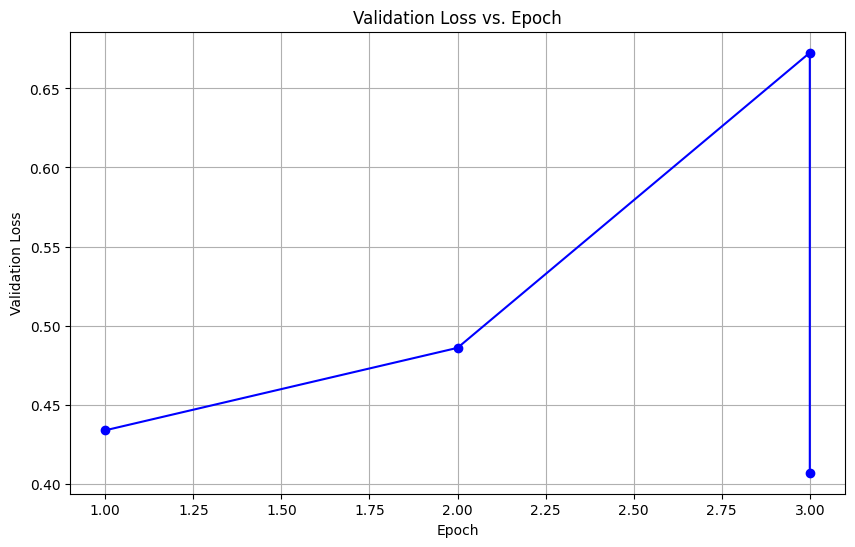

In [ ]:

# Plot the validation loss against epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')
plt.grid(True)
plt.show()

In [ ]:
epochs = []
train_losses = []
eval_losses = []

for log in swahbert_info:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'eval_accuracy' in log:
            train_losses.append(log['eval_accuracy'])
        if 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])

In [ ]:
print(train_losses)

[0.91842951430022, 0.9206295481468946, 0.9241834489761381, 0.9201218480284312]


In [ ]:
print(eval_losses)

[0.4337327480316162, 0.48589983582496643, 0.6725868582725525, 0.4069049656391144]


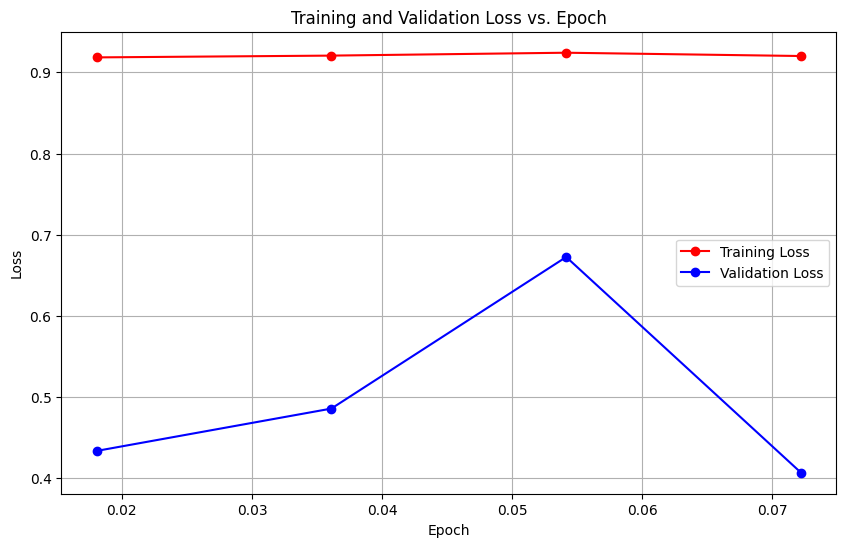

In [ ]:
# Plot the training loss and validation loss against epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_losses)], train_losses, marker='o', linestyle='-', color='r', label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, marker='o', linestyle='-', color='b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (164,) and (2,)

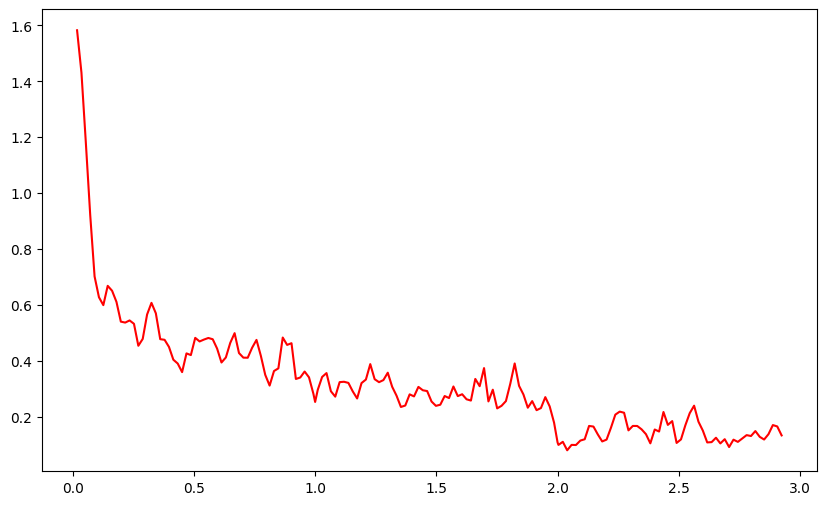

In [ ]:
#confusion matrix
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Calculate moving averages for smoothing
smoothed_train_losses = moving_average(train_losses)
smoothed_eval_losses = moving_average(eval_losses)
smoothed_epochs = epochs[:len(smoothed_train_losses)]  # Adjust epochs for valid convolution

# Plot the training loss and validation loss against epochs
plt.figure(figsize=(10, 6))
plt.plot(smoothed_epochs, smoothed_train_losses, linestyle='-', color='r', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_eval_losses, linestyle='-', color='b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()